# 1. Introduction

1) Feature Analysis  
2) Feature Engineering  
3) Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

%matplotlib inline

sns.set(style='white', context='notebook', palette='deep')

# 2. Load and Check Data

## 1) Load Data

In [2]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [3]:
IDtest = test["PassengerId"]

## 2) Outlier Detection

**Tukey Fences**  
사분위 범위(IQR; InterQuartile Range)를 기반으로 한다.  
Q1: 데이터셋의 값 중 첫번째의 25%를 보유하는 값  
Q3: 데이터셋의 값 중 세번째의 25%를 보유하는 값  
IQR = Q3 - Q1  
Outlier < Q1-(1.5\*IQR) or Q3+(1.5\*IQR) < Outlier  

(출처: https://cyan91.tistory.com/40)

In [4]:
def detect_outliers(df, n, features):
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5*IQR
        outlier_list_col = df[(df[col] < Q1-outlier_step) | (df[col] > Q3+outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers

In [5]:
Outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

C:\Users\L\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [6]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


**10 outliers**  
Ticket - 28, 89, 342  
SibSp - 그 외 7명

In [7]:
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

## 3) Joining Train and Test Set

In [8]:
train_len = len(train)

In [9]:
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

C:\Users\L\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


## 4) Check for Null and Missing Values

In [10]:
dataset = dataset.fillna(np.nan)

In [11]:
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


In [13]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [14]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [16]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 3. Feature Analysis

## 1) Numerical Values
SibSp, Parch, Age, Fare

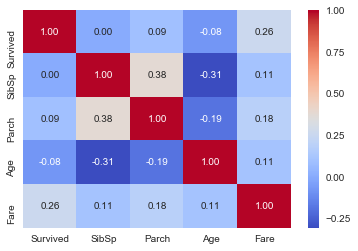

In [17]:
sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

### (1) SibSp

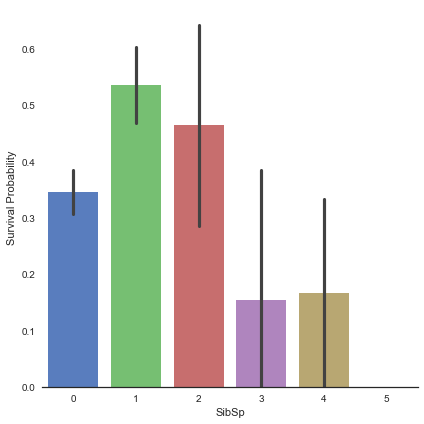

In [18]:
g = sns.factorplot(x='SibSp', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival Probability')

형제자매/배우자가 3명 이상이면 생존 확률 감소

### (2) Parch

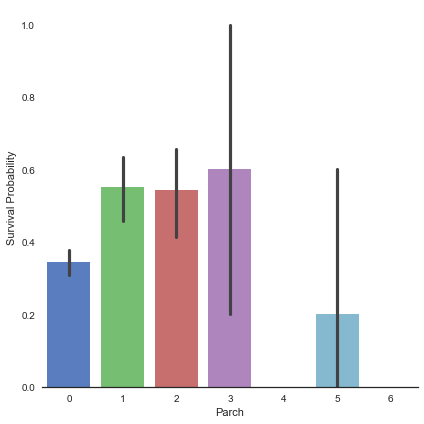

In [19]:
g = sns.factorplot(x='Parch', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival Probability')

독신, 대가족보다 소가족이 생존 가능성 높음  
부모자녀가 3명인 승객은 생존에 중요한 표준편차가 있음

### (3) Age

C:\Users\L\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\L\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


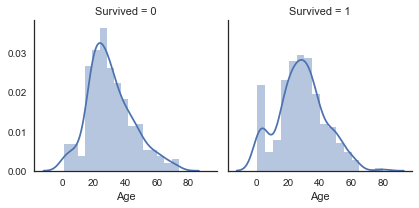

In [20]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

연령 분포는 가우스 분포처럼 보인다.  
60~80세 승객은 생존할 확률 적고, 아주 어린 승객은 생존할 확률이 높다.

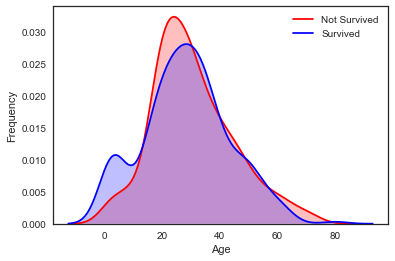

In [21]:
g = sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1) & (train['Age'].notnull())], ax=g, color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

### (4) Fare

In [22]:
dataset['Fare'].isnull().sum()

1

In [23]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

C:\Users\L\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


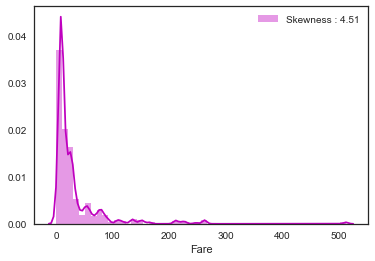

In [24]:
g = sns.distplot(dataset['Fare'], color='m', label='Skewness : %.2f' %(dataset['Fare'].skew()))
g = g.legend(loc='best')

**skewness(왜도)**  
데이터의 분포가 한쪽으로 쏠린 것을 의미한다.  

negative skew: 왼쪽에 꼬리를 가진(오른쪽에 데이터가 많은) 형태. -2 미만.  
positive skew: 오른쪽에 꼬리를 가진(왼쪽에 데이터가 많은) 형태. +2 초과.  

치우친 값을 그대로 학습시키면 꼬리부분이 상대적으로 적고 멀어서 모델에 영향이 거의 없이 학습된다. 그래서 정규성을 나타내도록 데이터를 변환해야 한다.  

negative skew: square, cube root, log2  
positive skew: square root, cube, log10  

(출처: https://rucrazia.tistory.com/65)

In [25]:
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i>0 else 0)

C:\Users\L\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


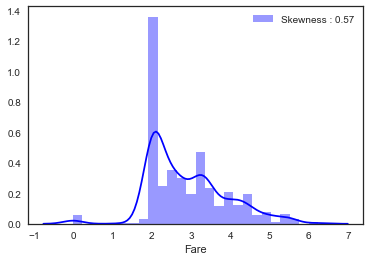

In [26]:
g = sns.distplot(dataset['Fare'], color='b', label='Skewness : %.2f' %(dataset['Fare'].skew()))
g = g.legend(loc='best')

## 2) Categorical Values
Sex, Pclass, Embarked

### (1) Sex

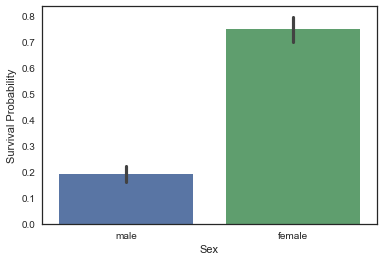

In [27]:
g = sns.barplot(x='Sex', y='Survived', data=train)
g = g.set_ylabel('Survival Probability')

In [28]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


남성보다 여성의 생존가능성 높음

### (2) Pclass

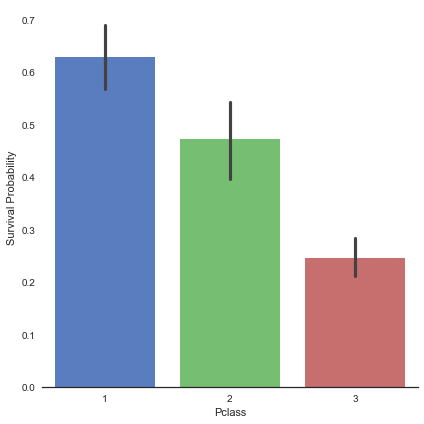

In [29]:
g = sns.factorplot(x='Pclass', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival Probability')

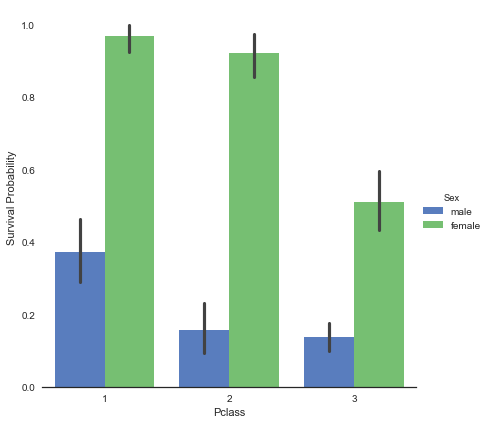

In [30]:
g = sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=train, size=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival Probability')

1등석 승객이 2등석, 3등석 승객보다 생존가능성 높음

### (3) Embarked

In [31]:
dataset['Embarked'].isnull().sum()

2

In [32]:
dataset['Embarked'] = dataset['Embarked'].fillna('S')

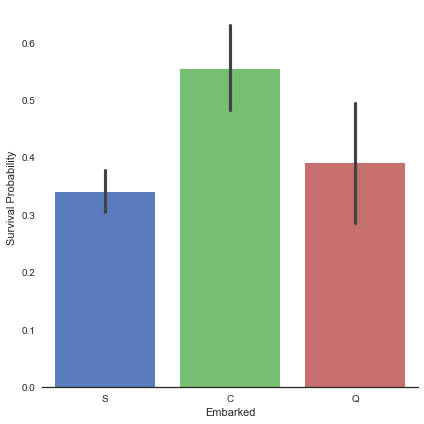

In [33]:
g = sns.factorplot(x='Embarked', y='Survived', data=train, size=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival Probability')

C 승선지 승객이 생존가능성 높음

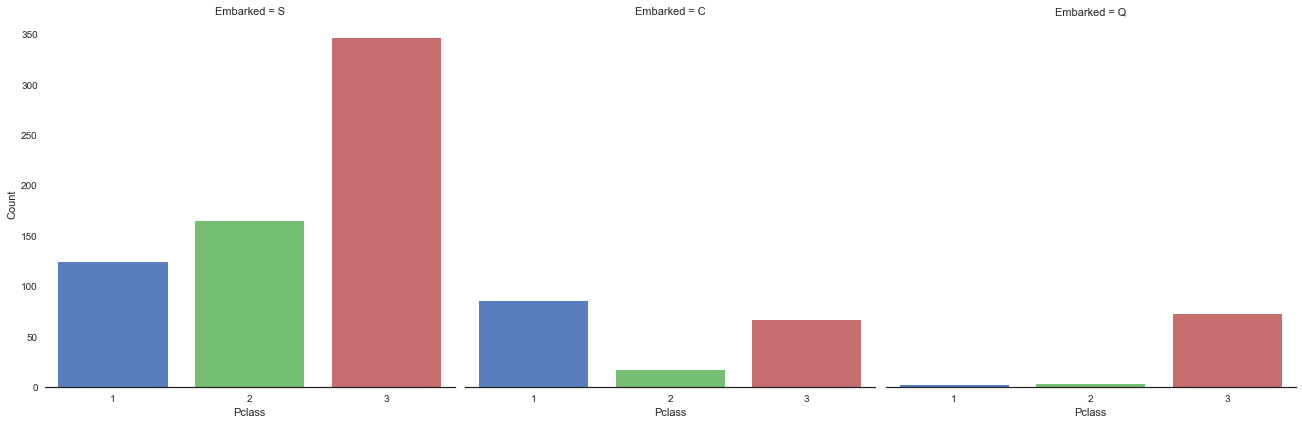

In [34]:
g = sns.factorplot('Pclass', col='Embarked', data=train, size=6, kind='count', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Count')

S, Q 승선지 승객들은 3등석을 많이 탔고, C 승선지 승객들은 1등석에 많이 탔다.

# 4. Filling Missing Values

## 1) Age

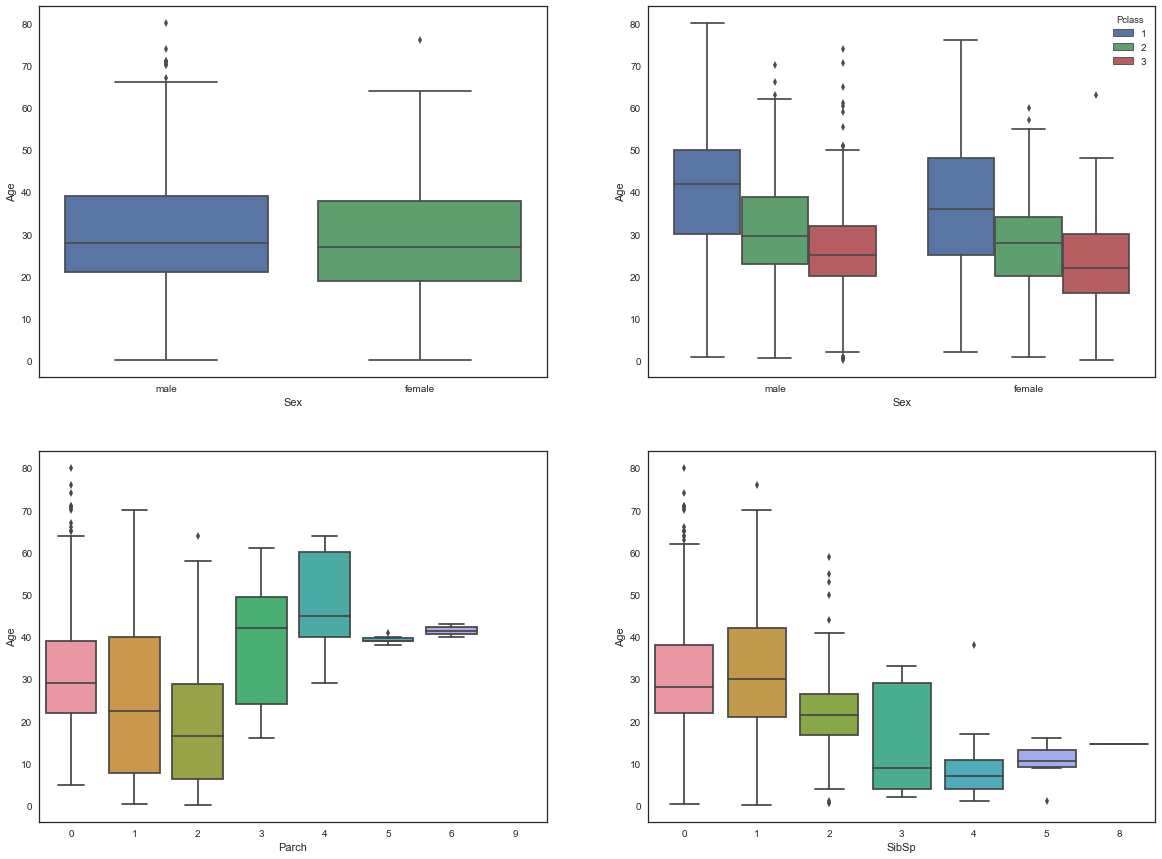

In [35]:
f, ax = plt.subplots(2, 2, figsize=(20, 15))

sns.factorplot(x='Sex', y='Age', data=dataset, kind='box', ax=ax[0,0])
sns.factorplot(x='Sex', y='Age', hue='Pclass', data=dataset, kind='box', ax=ax[0,1])
sns.factorplot(x='Parch', y='Age', data=dataset, kind='box', ax=ax[1,0])
sns.factorplot(x='SibSp', y='Age', data=dataset, kind='box', ax=ax[1,1])

plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
plt.show()

성별에 따른 연령 분포는 큰 차이 없음  
1등석 승객은 2등석, 3등석 승객보다 나이가 많음  
승객이 나이가 많을수록 부모자녀가 많고, 나이가 어릴수록 형제자매배우자가 많음

In [36]:
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})

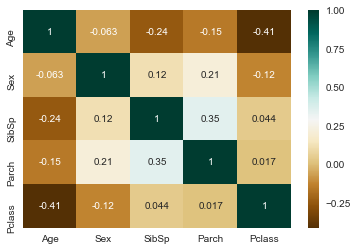

In [37]:
sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap='BrBG', annot=True)
plt.show()

Age는 Pclass, Parch, SibSp와 음의 상관관계가 있다.  
따라서, Age의 null 값을 Pclass, Parch, SibSp을 이용해서 채워넣는다.

In [38]:
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

In [39]:
for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp']==dataset.iloc[i]['SibSp']) 
                               & (dataset['Parch']==dataset.iloc[i]['Parch']) 
                               & (dataset['Pclass']==dataset.iloc[i]['Pclass']))].median()
    
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

C:\Users\L\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


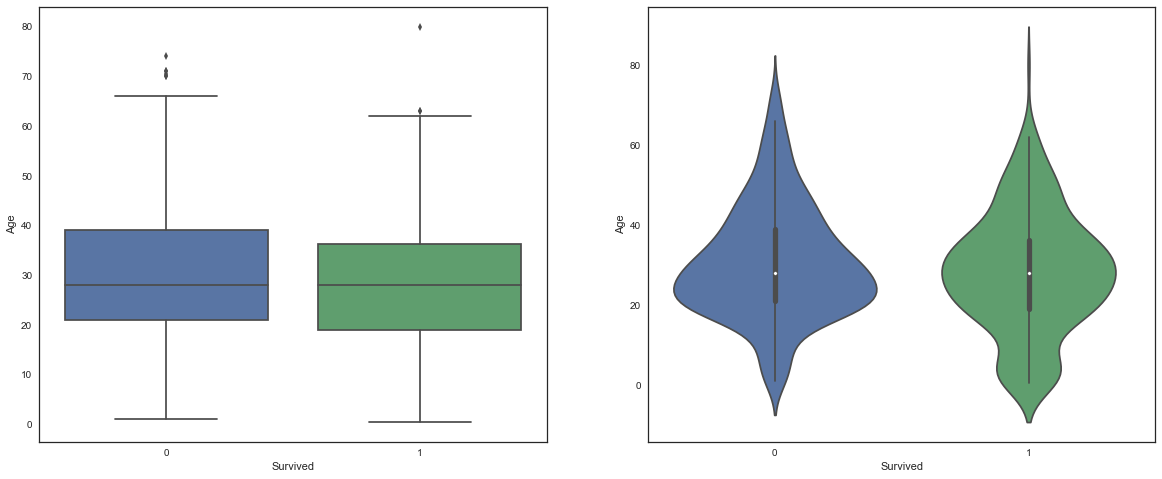

In [40]:
f, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.factorplot(x='Survived', y='Age', data=train, kind='box', ax=ax[0])
sns.factorplot(x='Survived', y='Age', data=train, kind='violin', ax=ax[1])

plt.close(2)
plt.close(3)
plt.show()

# 5. Feature Engineering

## 1) Name/Title

In [41]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [42]:
dataset_title = [i.split(',')[1].split(".")[0].strip() for i in dataset['Name']]

In [43]:
dataset['Title'] = pd.Series(dataset_title)

In [44]:
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

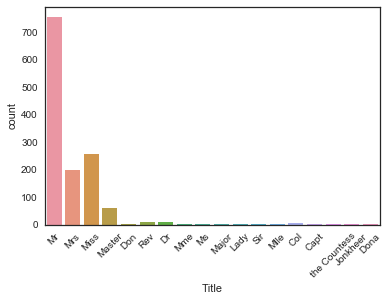

In [45]:
g = sns.countplot(x='Title', data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

In [46]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

In [47]:
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})

In [48]:
dataset['Title'] = dataset['Title'].astype(int)

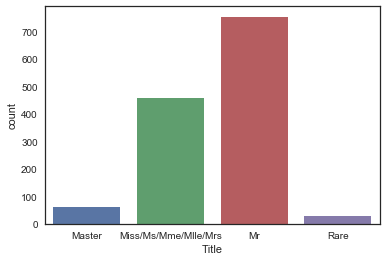

In [49]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master', 'Miss/Ms/Mme/Mlle/Mrs', 'Mr', 'Rare'])

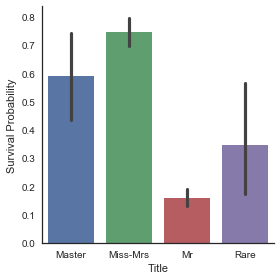

In [50]:
g = sns.factorplot(x='Title', y='Survived', data=dataset, kind='bar')
g = g.set_xticklabels(['Master', 'Miss-Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('Survival Probability')

여자, 아이들이 생존가능성이 높고, 특이하게 희귀 타이틀을 가진 승객이 생존가능성 높음

In [51]:
dataset.drop(labels=['Name'], axis=1, inplace=True)

## 2) Family Size

In [52]:
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

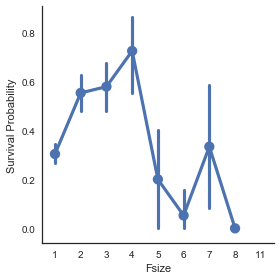

In [53]:
g = sns.factorplot(x='Fsize', y='Survived', data=dataset)
g = g.set_ylabels('Survival Probability')

In [54]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s==1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s==2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3<=s<=4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s>=5 else 0)

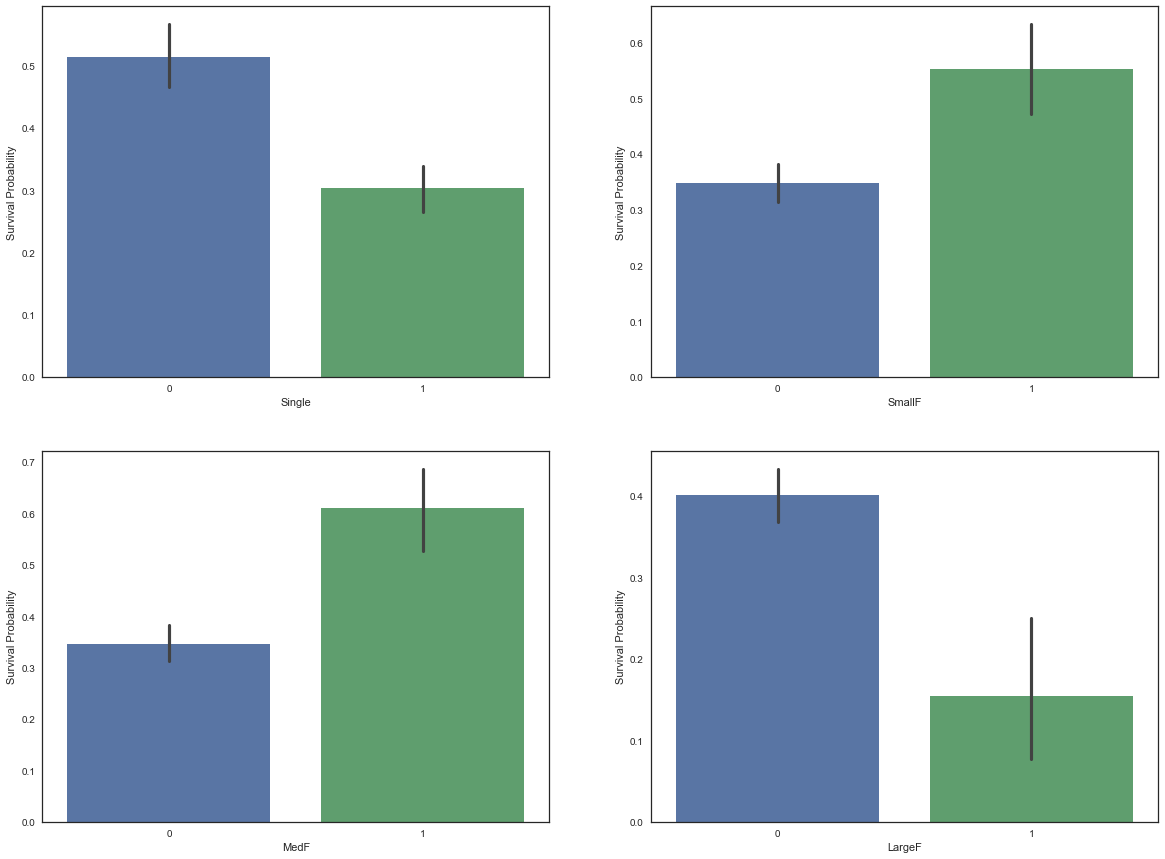

In [55]:
f, ax = plt.subplots(2, 2, figsize=(20, 15))

sns.factorplot(x='Single', y='Survived', data=dataset, kind='bar', ax=ax[0,0])
ax[0,0].set_ylabel('Survival Probability')

sns.factorplot(x='SmallF', y='Survived', data=dataset, kind='bar', ax=ax[0,1])
ax[0,1].set_ylabel('Survival Probability')

sns.factorplot(x='MedF', y='Survived', data=dataset, kind='bar', ax=ax[1,0])
ax[1,0].set_ylabel('Survival Probability')

sns.factorplot(x='LargeF', y='Survived', data=dataset, kind='bar', ax=ax[1,1])
ax[1,1].set_ylabel('Survival Probability')

plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
plt.show()

독신, 대가족보다 중소가족의 생존가능성 높음

In [56]:
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix='Em')

In [57]:
dataset.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,22.0,NaN,1.981001,0,1,3,0,1,0.0,A/5 21171,...,1,0,0,0,0,1,0,0,0,1
1,38.0,C85,4.266662,0,2,1,1,1,1.0,PC 17599,...,1,0,0,0,1,0,0,1,0,0
2,26.0,NaN,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,...,0,0,0,0,1,0,0,0,0,1
3,35.0,C123,3.972177,0,4,1,1,1,1.0,113803,...,1,0,0,0,1,0,0,0,0,1
4,35.0,NaN,2.085672,0,5,3,0,0,0.0,373450,...,0,0,0,0,0,1,0,0,0,1


## 3) Cabin

In [58]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [59]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [60]:
dataset['Cabin'].isnull().sum()

1007

In [61]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [62]:
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

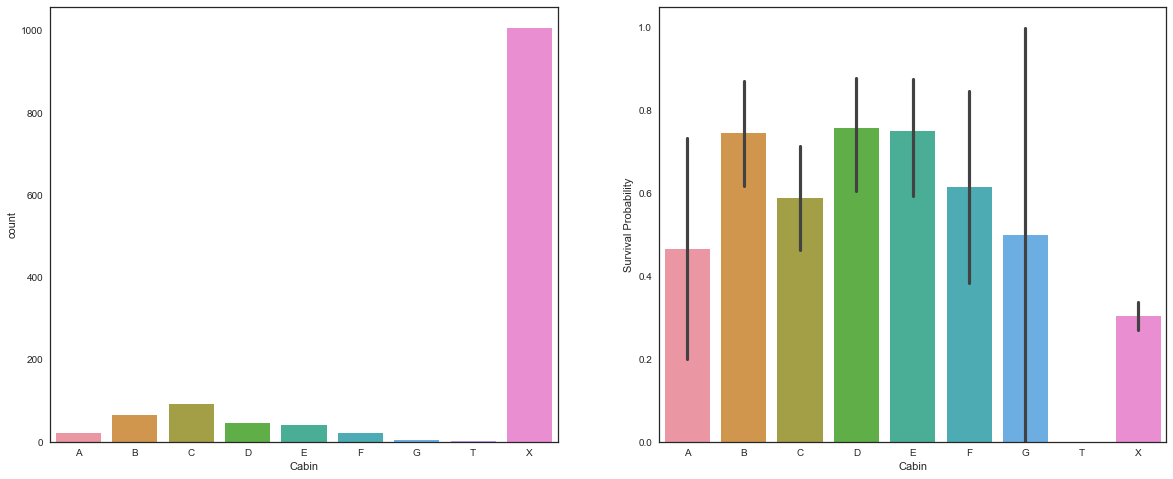

In [63]:
f, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.countplot(dataset['Cabin'], order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'], ax=ax[0])
sns.factorplot(x='Cabin', y='Survived', data=dataset, kind='bar', order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'], ax=ax[1])
ax[1].set_ylabel('Survival Probability')

plt.close(2)
plt.close(3)
plt.show()

객실이 있는 승객은 일반적으로 없는 경우보다 생존가능성 높음

In [64]:
dataset = pd.get_dummies(dataset, columns=['Cabin'], prefix='Cabin')

## 4) Ticket

In [65]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

접두사가 동일한 티켓은 Pclass, 생존율이 유사할 수 있다.

In [66]:
Ticket = []

In [67]:
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".", "").replace("/", "").strip().split(' ')[0])
    else:
        Ticket.append('X')

In [68]:
dataset['Ticket'] = Ticket

In [69]:
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [70]:
dataset = pd.get_dummies(dataset, columns=['Ticket'], prefix='T')    # one-hot encoding

In [71]:
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns=['Pclass'], prefix='Pc')    # one-hot encoding

In [72]:
dataset.drop(labels=['PassengerId'], axis=1, inplace=True)

In [73]:
dataset.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,0.0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1.0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,0.0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


# 6. Modeling 

In [74]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'], axis=1, inplace=True)

C:\Users\L\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [75]:
train['Survived'] = train['Survived'].astype(int)
Y_train = train['Survived']
X_train = train.drop(labels=['Survived'], axis=1)

C:\Users\L\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## 1) Simple Modeling

### (1) Cross Validate Models

1) SVC  
2) Decision Tree  
3) AdaBoost  
4) Random Forest  
5) Extra Trees  
6) Gradient Boosting  
7) Multiple layer perceprton (neural network)  
8) KNN  
9) Logistic regression  
10) Linear Discriminant Analysis

In [76]:
kfold = StratifiedKFold(n_splits=10)

In [77]:
random_state = 2
classifiers = []
cv_results = []
cv_means = []
cv_std = []

In [78]:
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

In [79]:
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring='accuracy', cv=kfold, n_jobs=4))

In [80]:
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [81]:
cv_res = pd.DataFrame({'CrossValMeans':cv_means,
                       'CrossValerrors': cv_std,
                       'Algorithm':['SVC', 'DecisionTree', 'AdaBoost', 'RandomForest', 'ExtraTrees', 'GradientBoosting', 'MultipleLayerPerceptron', 'KNeighboors', 'LogisticRegression', 'LinearDiscriminantAnalysis']})

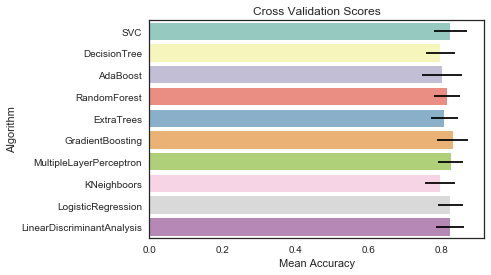

In [82]:
g = sns.barplot('CrossValMeans', 'Algorithm', data=cv_res, palette='Set3', orient='h', **{'xerr':cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross Validation Scores')

### (2) Hyperparameter Tunning for Best Models

**AdaBoost**

In [83]:
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {'base_estimator__criterion':['gini', 'entropy'],
                 'base_estimator__splitter':['best', 'random'],
                 'algorithm':['SAMME', 'SAMME.R'],
                 'n_estimators':[1, 2],
                 'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

In [84]:
gsadaDTC.fit(X_train,Y_train)

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Done  50 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:   14.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=7),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'base_estimator__criterion': ['gini', 'entropy'], 'base_estimator__splitter': ['best', 'random'], 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1, 2], 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [85]:
ada_best = gsadaDTC.best_estimator_
gsadaDTC.best_score_

0.8240635641316686

**ExtraTrees**

In [86]:
ExtC = ExtraTreesClassifier()

ex_param_grid = {'max_depth':[None],
                'max_features':[1,3,10],
                'min_samples_split':[2,3,10],
                'min_samples_leaf':[1,3,10],
                'bootstrap':[False],
                'n_estimators':[100,300],
                'criterion':['gini']}

gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

In [87]:
gsExtC.fit(X_train, Y_train)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   17.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   40.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'max_depth': [None], 'max_features': [1, 3, 10], 'min_samples_split': [2, 3, 10], 'min_samples_leaf': [1, 3, 10], 'bootstrap': [False], 'n_estimators': [100, 300], 'criterion': ['gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [88]:
ExtC_best = gsExtC.best_estimator_
gsExtC.best_score_

0.8342792281498297

**RandomForest**

In [89]:
RFC = RandomForestClassifier()

rf_param_grid = {'max_depth':[None],
                'max_features':[1,3,10],
                'min_samples_split':[2,3,10],
                'min_samples_leaf':[1,3,10],
                'bootstrap':[False],
                'n_estimators':[100,300],
                'criterion':['gini']}

gsRFC = GridSearchCV(RFC, param_grid=rf_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

In [90]:
gsRFC.fit(X_train, Y_train)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   20.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   44.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'max_depth': [None], 'max_features': [1, 3, 10], 'min_samples_split': [2, 3, 10], 'min_samples_leaf': [1, 3, 10], 'bootstrap': [False], 'n_estimators': [100, 300], 'criterion': ['gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [91]:
RFC_best = gsRFC.best_estimator_
gsRFC.best_score_

0.8320090805902384

**Gradient Boosting**

In [92]:
GBC = GradientBoostingClassifier()

gb_param_grid = {'loss':['deviance'],
                'n_estimators':[100,200,300],
                'learning_rate':[0.1,0.05,0.01],
                'max_depth':[4,8],
                'min_samples_leaf':[100,150],
                'max_features':[0.3,0.1]}

gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

In [93]:
gsGBC.fit(X_train, Y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   37.8s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   55.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'loss': ['deviance'], 'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.05, 0.01], 'max_depth': [4, 8], 'min_samples_leaf': [100, 150], 'max_features': [0.3, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [94]:
GBC_best = gsGBC.best_estimator_
gsGBC.best_score_

0.8365493757094211

**SVC**

In [95]:
SVMC = SVC(probability=True)

svc_param_grid = {'kernel':['rbf'],
                 'gamma':[0.001,0.01,0.1,1],
                 'C':[1,10,50,100,200,300,1000]}

gsSVMC = GridSearchCV(SVMC, param_grid=svc_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

In [96]:
gsSVMC.fit(X_train, Y_train)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   39.2s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:  1.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.1, 1], 'C': [1, 10, 50, 100, 200, 300, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [97]:
SVMC_best = gsSVMC.best_estimator_
gsSVMC.best_score_

0.8331441543700341

### (3) Plot Learning Curves

In [98]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc='best')
    
    return plt

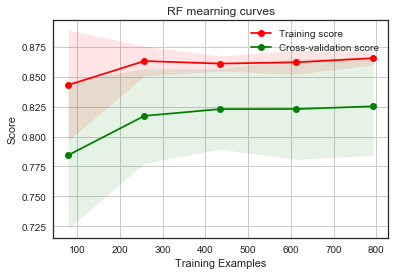

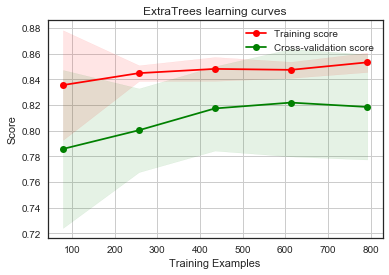

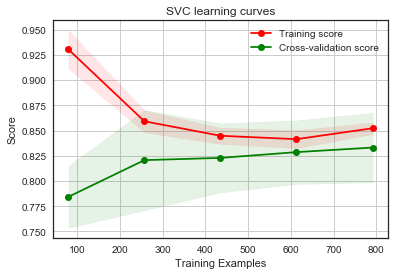

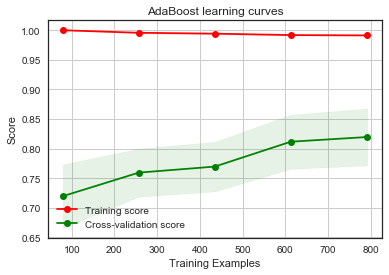

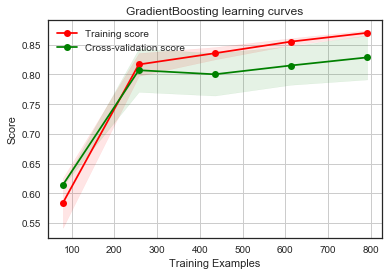

In [99]:
g = plot_learning_curve(gsRFC.best_estimator_, "RF mearning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_, "ExtraTrees learning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_, "SVC learning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_, "AdaBoost learning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_, "GradientBoosting learning curves", X_train, Y_train, cv=kfold)

### (4) Feature Importance of the Tree Based Classifiers

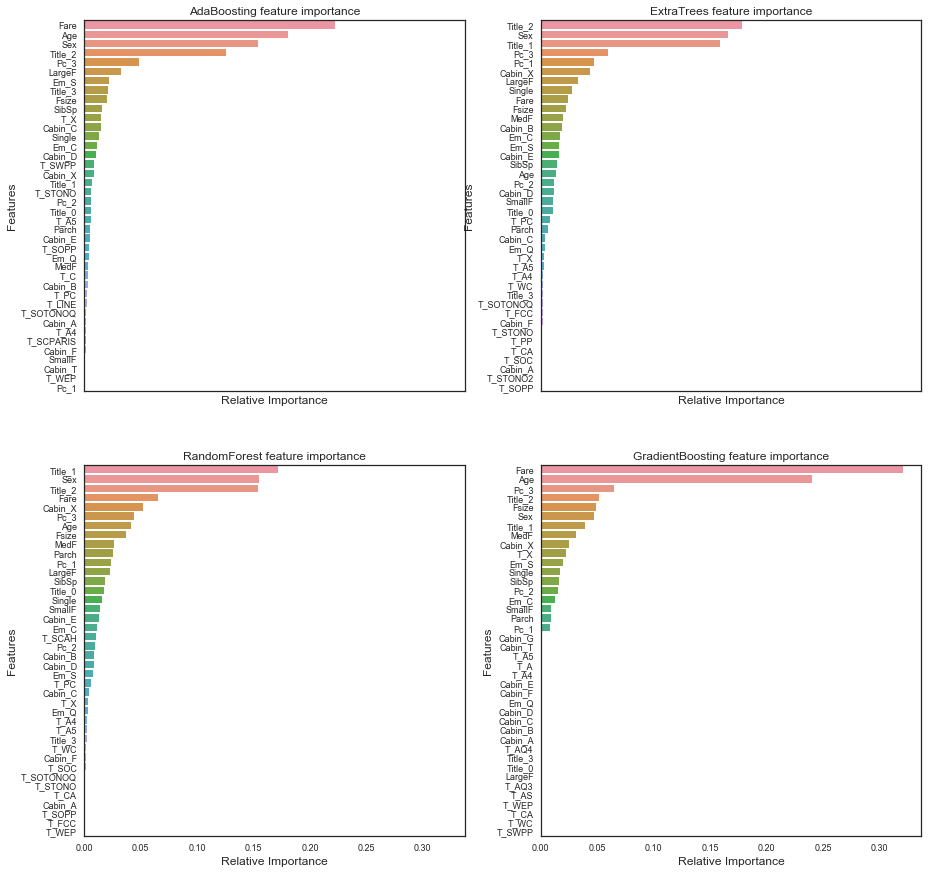

In [100]:
nrows = ncols = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex='all', figsize=(15,15))

names_classifiers = [('AdaBoosting', ada_best), ('ExtraTrees', ExtC_best), ('RandomForest', RFC_best), ('GradientBoosting', GBC_best)]

nclassifier = 0

for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        
        g = sns.barplot(x=classifier.feature_importances_[indices][:40], y=X_train.columns[indices][:40], orient='h', ax=axes[row][col])
        g.set_xlabel('Relative Importance', fontsize=12)
        g.set_ylabel('Features', fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + ' feature importance')
        nclassifier += 1

중요한 feature: Fare, Title_2, Age, Sex

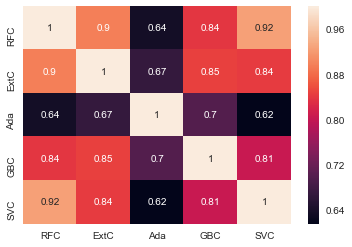

In [101]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name='RFC')
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name='ExtC')
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name='SVC')
test_Survived_AdaC = pd.Series(ada_best.predict(test), name='Ada')
test_Survived_GBC = pd.Series(GBC_best.predict(test), name='GBC')

ensemble_results = pd.concat([test_Survived_RFC, test_Survived_ExtC, test_Survived_AdaC, test_Survived_GBC, test_Survived_SVMC], axis=1)

g = sns.heatmap(ensemble_results.corr(), annot=True)

## 2) Ensemble Modeling

### (1) Combining Models

In [102]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('svc', SVMC_best), ('adac', ada_best), ('gbc', GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

## 3) Prediction

### (1) Predict and Submit Results

In [103]:
test_Survived = pd.Series(votingC.predict(test), name='Survived')

C:\Users\L\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [104]:
results = pd.concat([IDtest, test_Survived], axis=1)

In [105]:
results.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
